In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csc_matrix
from networkx.algorithms import community
import matplotlib.pyplot as plt
import psycopg2 as pg2
from pprint import pprint
import pandas as pd

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/home/consulting/Jupyter/smnoh/font/NanumGothic.ttf").get_name()
rc('font', family=font_name)

### 뉴스 데이터로 그래프 생성

In [3]:
# connect PostgreSQL
def query_agens(query):
    import psycopg2 as pg2
    from psycopg2 import Error
    from datetime import datetime
    
    start_tm = datetime.now()
    conn = pg2.connect(database="kg_news", user="consulting", host="192.168.0.68", port="15432")
    cur = conn.cursor()

    path_query = "set graph_path = realestate_news_v3;"
    cur.execute(path_query)
    cur.execute(query)
    result = cur.fetchall()
    
    cur.close()
    conn.close()
    
    end_tm = datetime.now()
    print('START: ', str(start_tm))
    print('END: ', str(end_tm))
    print('ELAP: ', str(end_tm - start_tm))
    
    return result

In [4]:
query = """match (s:noun)-[p:predicate]->(o:noun) return s.word, p.verb, o.word"""
result = query_agens(query)
data = pd.DataFrame(result, columns=['subject', 'predicate', 'object'])
data

START:  2021-01-08 08:43:54.618137
END:  2021-01-08 08:43:54.637579
ELAP:  0:00:00.019442


,subject,predicate,object
0,정부,발표하다,임대주택 공급
1,정부,위하다,전세시장안정
2,정부,계획이다,전세 대책 발표
3,정부,진행하다,관계부처간 협의
4,정부,옳다,대응방안 마련
...,...,...,...
964,공공임대,필수적이다,지속성
965,공공임대,필수적이다,사업성
966,공공임대,줄여야한다,정부역할
967,공공임대,지적하다,공급대책


#### 방향성 없는 graph 생성

In [5]:
G = nx.Graph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거 
G.add_nodes_from(node)

for i in data.index:
    G.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [6]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 886\nAverage degree:   1.9261'

#### 방향성 있는 그래프 생성(사용하진 않음)

In [101]:
G1 = nx.DiGraph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거
G1.add_nodes_from(node)

for i in data.index:
    G1.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [193]:
nx.info(G1)

'Name: \nType: DiGraph\nNumber of nodes: 920\nNumber of edges: 897\nAverage in degree:   0.9750\nAverage out degree:   0.9750'

#### 엣지라벨 시각화하는 방법

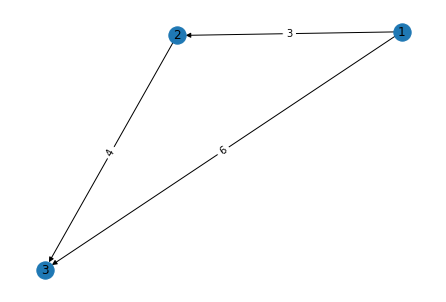

In [115]:
g3 = nx.DiGraph() 

g3.add_weighted_edges_from([(1, 2, 3), (2, 3, 4)])
g3.add_edge(1, 3, weight = 6)

pos=nx.kamada_kawai_layout(g3)
nx.draw(g3, pos = pos, with_labels = True)

labels = nx.get_edge_attributes(g3,'weight')
nx.draw_networkx_edge_labels(g3, pos, edge_labels = labels);

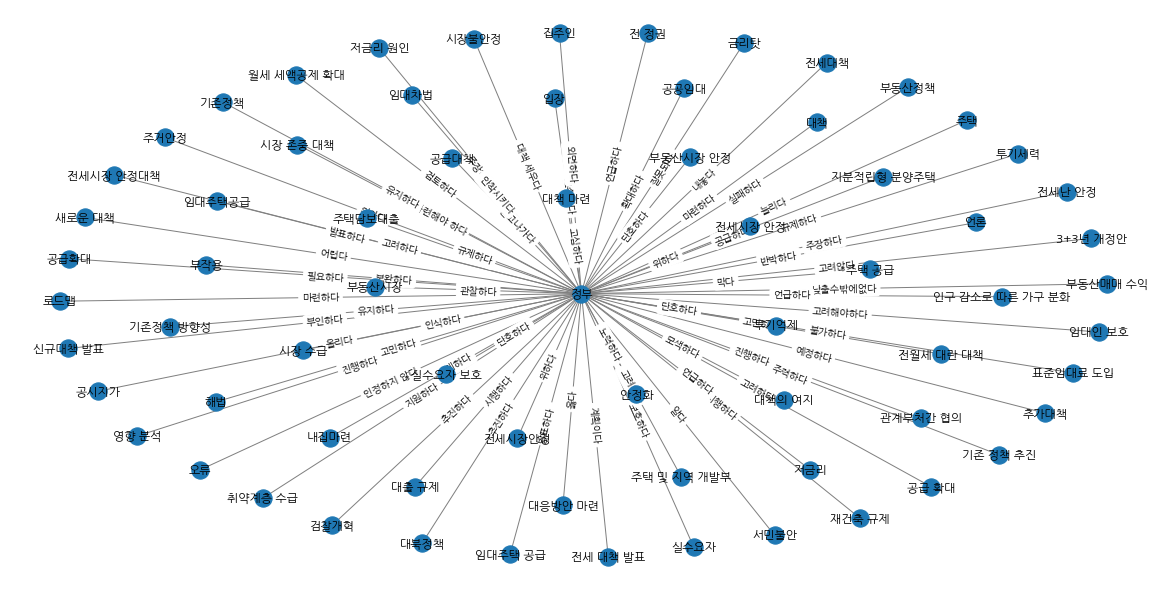

In [151]:
#엣지라벨 보이게 하기
plt.figure(figsize=(16, 8))
pos=nx.kamada_kawai_layout(G) # layout 종류 바꾸면 그림이 달라짐 'kamada_kawai_layout' 아니면 'spring_layout'
nx.draw(G, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray') # 그래프를 그리고

labels = nx.get_edge_attributes(G,'verb')
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_family=font_name)  # 라벨 추가
plt.show()

### Hierarchical Graph Clustering using Girvan-Newman clustering
https://www.pnas.org/content/99/12/7821

In [7]:
def GN_HC(G): 
    # g는 Edge를 끊어나가는 네트워크 
    g = G.copy()
    """ initial """
    step = 0                # step 초기화
    log_step = []           # step 기록
    log_modularity = []     # modularity 기록
    log_num=[]              # cluster 갯수 기록 
    k = sorted(nx.connected_components(G), key=len, reverse=True)   # k 는 모두 연결되어있는 Community를 노드로 나타낸 값
    m = community.modularity(G, communities=k)   # modularity
    k_num=0
    target_k=[]   #각각의 k_list를 다 더한게 target_k
    
    num_edges=[] #엣지 개수 기록
    """ Girvan-Newman algorithm """
    #엣지가 다 없어질때까지 계속함?? 
    while len(g.edges()) > 0:
        # 지금 연결된 component들
        k = sorted(nx.connected_components(g), key=len, reverse=True)  # 커뮤니티 추출
        m = community.modularity(G, communities=k)   # 추출된 커뮤니티의 modularity 계산
        k_list = []
        num_edge = g.number_of_edges()
        
        for j in range(len(k)):
            k_list.append(k[j])  # 단계마다의 k를 k_list에 담음?? 
        #print(k_list)
        
        #새로운 클러스터의 개수가 기존 클러스터의 개수보다 크다면, 
        if len(k_list)>k_num: # 클러스터 갯수가 변할때마다 기록(1부터 시작), 여기에서의 k_num은 엣지가 제거되기 전의 클러스터 개수
            target_k.append(k_list) #결국에 target_k의 요소들은 다 k들임(component). k[i]는 커뮤니티개수가 i일 때의 커뮤니티가 아님
            k_num=len(k_list)  # 클러스터의 개수?? 
            log_modularity.append(m)   # 로깅용
            log_step.append(step)    # 로깅용
            log_num.append(k_num)
            num_edges.append(num_edge)
        
        """ remove edge """
        step += 1
        betweenness = nx.edge_betweenness_centrality(g)  # betweennes centrality 계산
        max_edge = max(betweenness, key=betweenness.get)    # betweeness centrality가 가장 큰 Edge 선택
        g.remove_edge(max_edge[0], max_edge[1])     # 선택된 Edge 제거
        #다시 돌아가면 엣지가 하나 제거된 그래프의 컴포넌트부터 계산해서 다시 시작됨. 
        
    return log_step, log_modularity, log_num, num_edges, target_k

In [14]:
# cluster 리스트에서 원하는 cluster 갯수 만큼 추출
def find_cluster(n):
    global log_num, target_k
    #pprint(target_k[n-1])
    return target_k[n-1]

#### Karate Club 데이터 예제

In [284]:
test_karate=np.loadtxt('/home/consulting/Jupyter/adrianj/Data/Network/karate_network.txt')
karate_bin=test_karate[:34,:]
karate_val=test_karate[34:,:]

In [526]:
G_karate = nx.Graph(karate_bin)
log_step, log_modularity, log_num, num_edges, target_k = GN_HC(G_karate)

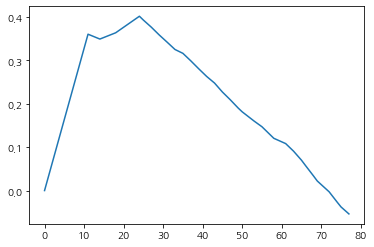

In [527]:
plt.plot(log_step,log_modularity)

#### SPO 데이터 적용
- 1.1 에서 생성한 그래프 G 사용

In [8]:
#GN방식 클러스터링 수행
log_step, log_modularity, log_num, num_edges, target_k = GN_HC(G)

In [10]:
#각 클러스터의 사이즈 확인
#input Graph에 connected component가 129개 있기 때문에 n=1일 때도 129개의 클러스터가 추출됨 -> Giant Component만으로 클러스터링 다시 진행
n=1
print('#of clusters:', len(find_cluster(n)))
print('size of each cluster')
print([len(i) for i in find_cluster(n)])

#of clusters: 129
size of each cluster
[569, 9, 9, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


##### Giant Component로 그래프 생성하기

In [8]:
gc_nodes = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])

#주어
query1 = "match (s:noun)-[r:predicate]->(o:noun) where s.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result1 = query_agens(query1)
data1 = pd.DataFrame(result1, columns=['subject', 'predicate', 'object'])

#목적어
query2 = "match (s:noun)-[r:predicate]->(o:noun) where o.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result2 = query_agens(query2)
data2 = pd.DataFrame(result2, columns=['subject', 'predicate', 'object'])

gc_df = pd.concat([data1, data2], ignore_index=True)
gc_df = gc_df.drop_duplicates()

START:  2021-01-08 08:44:41.516532
END:  2021-01-08 08:44:41.540506
ELAP:  0:00:00.023974
START:  2021-01-08 08:44:41.542436
END:  2021-01-08 08:44:41.565845
ELAP:  0:00:00.023409


In [9]:
G1 = nx.Graph()

#노드추가
nouns = list(gc_df.subject) + list(gc_df.object)
node = set(nouns)
G1.add_nodes_from(node)

#엣지추가
for i in gc_df.index:
    G1.add_edges_from([(gc_df.subject[i], gc_df.object[i], {'verb':gc_df.predicate[i]})])

In [10]:
nx.info(G1)

'Name: \nType: Graph\nNumber of nodes: 569\nNumber of edges: 662\nAverage degree:   2.3269'

##### Giant Component 그래프로 클러스터링

In [11]:
#다 연결되어 있음!
len(sorted(nx.connected_components(G1), key=len, reverse=True))

1

In [12]:
log_step, log_modularity, log_num, num_edges, target_k = GN_HC(G1)

In [15]:
#클러스터가 n개인 그래프 생성
n=10
clusters = find_cluster(n)
#각 클러스터의 사이즈 확인
[len(i) for i in clusters]

[112, 98, 80, 54, 51, 50, 49, 33, 22, 20]

##### Modularity가 최대인 군집 개수

In [21]:
max_m = max(log_modularity)
print('max_modularity :',max_m)

max_m_idx = log_modularity.index(max_m)
print('optimized # of clusters :',log_num[max_m_idx])

max_modularity : 0.7843975045866023
optimized # of clusters : 21


- Plot Modularity

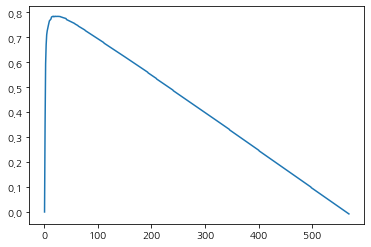

In [532]:
plt.plot(log_num,log_modularity)

- 군집 수 cutoff using Entropy?? (ranyi disparity)

In [22]:
import math

normal_size = []
total = sum(size)
for i in size:
    normal_size.append(i/total)

w=[]
for i in normal_size:
    w.append(i*math.log(i))

math.exp(-sum(w))  # 17개 이하인 군집은 버리기?? (정확한 해석법은 잘모름)

16.752768048320377

##### 클러스터별 SPO 리스트업

In [23]:
#클러스터별 노드 개수 확인
clusters = find_cluster(21)
size = [len(i) for i in clusters]
print(size)

[84, 61, 47, 42, 41, 34, 33, 30, 26, 24, 22, 20, 20, 19, 15, 11, 10, 8, 8, 8, 6]


In [24]:
print(clusters[1])

{'국민 기본권', '월세시장', '전세기간 연장', '수급불균형', '사회적 유대감', '7월 말', '설문조사', '사회적 연대', '전세물량', '전세 물량 부족', '위헌 소지', '연대', '전통적 전세대책', '3개월', '부동산시장 과열', '분쟁', '민간임대주택', '공급량', '윤호중 의원', '계약갱신청구권', '문의', '수도권 주민', '꼼수', '전월세상한제', '후속 대책', '적용', '사회적 시장경제질서', '임대차보호법', '혼란', '혼선', '2015년 9·2 대책', '7월 31일', '결과', '공급불안', '임대차법', '부동산대책', '더불어민주당', '리모델링 매입임대', '소급', '정부여당', '사업', '월세 전환', '축조심사', '세 달', '이 시점', '임대료 증액', '사회적시장경제질서', '재산권 침해', '전문가', '3달', '제도 변경', '여론조사기관', '계약의 자유', '전방위', '지적', '국민의 재산권', '임대차', '상가시장', '3+3 개정안', '월세전환', '정책남발'}


In [25]:
#전체 그래프의 엣지리스트
edgelist = nx.get_edge_attributes(G1,'verb')

In [26]:
#클러스터별 SPO 추출
spolist = {}
for k in range(len(clusters)):
    nodepair = []
    for i in clusters[k]:
        for j in clusters[k]:
            a = (i,j)
            nodepair.append(a)
    spo = {}
    for i in nodepair:
        try:
            spo[i] = edgelist[i]
            
        except KeyError:
            continue
    spolist[k] = spo

In [27]:
spolist[0]

{('국민들 신음', '부작용'): '소급적용되다',
 ('실수요자보호', '의지'): '단호하다',
 ('주거안정', '정부'): '위하다',
 ('전세 대책 발표', '정부'): '계획이다',
 ('야당', '홍남기 전세 난민'): '지렛대 삼다',
 ('야당', '부동산정책'): '비판하다',
 ('2023년', '지분적립형 분양주택'): '가능하다',
 ('의지', '투기억제'): '단호하다',
 ('로드맵', '전세공급'): '지속하다',
 ('로드맵', '정부'): '마련하다',
 ('로드맵', '임대주택'): '공급하다',
 ('도입', '3+3년 개정안'): '파국이다',
 ('부동산시장안정', '의지'): '단호하다',
 ('오류', '정부'): '인정하지 않다',
 ('오류', '목적지'): '멀어지다',
 ('대책 마련', '정부'): '고심하다',
 ('대출 규제', '정부'): '시행하다',
 ('새로운 대책', '기존대책'): '충돌하다',
 ('새로운 대책', '매매시장 안정대책'): '충돌할 수 있다',
 ('추가대책', '홍남기 부총리'): '고민하다',
 ('무조건', '추가대책'): '만들지않다',
 ('전세자금대출증가', '원인'): '명확하지 않다',
 ('분노', '해법'): '확산하다',
 ('인구 감소로 따른 가구 분화', '정부'): '언급하다',
 ('임대주택 공급', '정부'): '발표하다',
 ('부동산정책', '집값상승'): '응답하다',
 ('부동산정책', '정부'): '실패하다',
 ('기존정책 방향성', '정부'): '유지하다',
 ('시장 수급', '부동산 시정 안정'): '만들다',
 ('신규대책 발표', '정부'): '부인하다',
 ('신설', '주택 및 지역 개발부'): '검토하다',
 ('전세시장안정', '정부'): '위하다',
 ('지분적립형 분양주택', '공급 모델'): '기대되다',
 ('지분적립형 분양주택', '정부'): '공급하다',
 ('지분적립형 분양주택', '도심'): '적용되다'

In [28]:
[len(spolist[i]) for i in range(len(spolist))]

[84, 66, 51, 42, 43, 34, 32, 30, 25, 24, 21, 20, 19, 18, 14, 10, 9, 7, 7, 7, 5]

In [29]:
#각 클러스터별 SPO 리스트 확인
spolist[20]

{('확대', '주택공급'): '추진하다',
 ('확대', '주택 공급'): '어렵다',
 ('규제강화', '주택공급'): '감소하다',
 ('재건축', '주택 공급'): '감소하다',
 ('주택 공급', '재개발'): '감소하다'}

In [30]:
#추출된 SPO리스트에서 클러스터별 명사 개수 확인하여 대조
nounlist = []
for i in range(len(spolist)):
    keys = list(spolist[i].keys())
    nouns = []
    for i in keys:
        nouns.append(i[0])
        nouns.append(i[1])
    nouns = set(nouns)
    nounlist.append(nouns)

In [31]:
print([len(nounlist[i]) for i in range(len(nounlist))])

[84, 61, 47, 42, 41, 34, 33, 30, 26, 24, 22, 20, 20, 19, 15, 11, 10, 8, 8, 8, 6]


##### 시각화

- 전체그래프

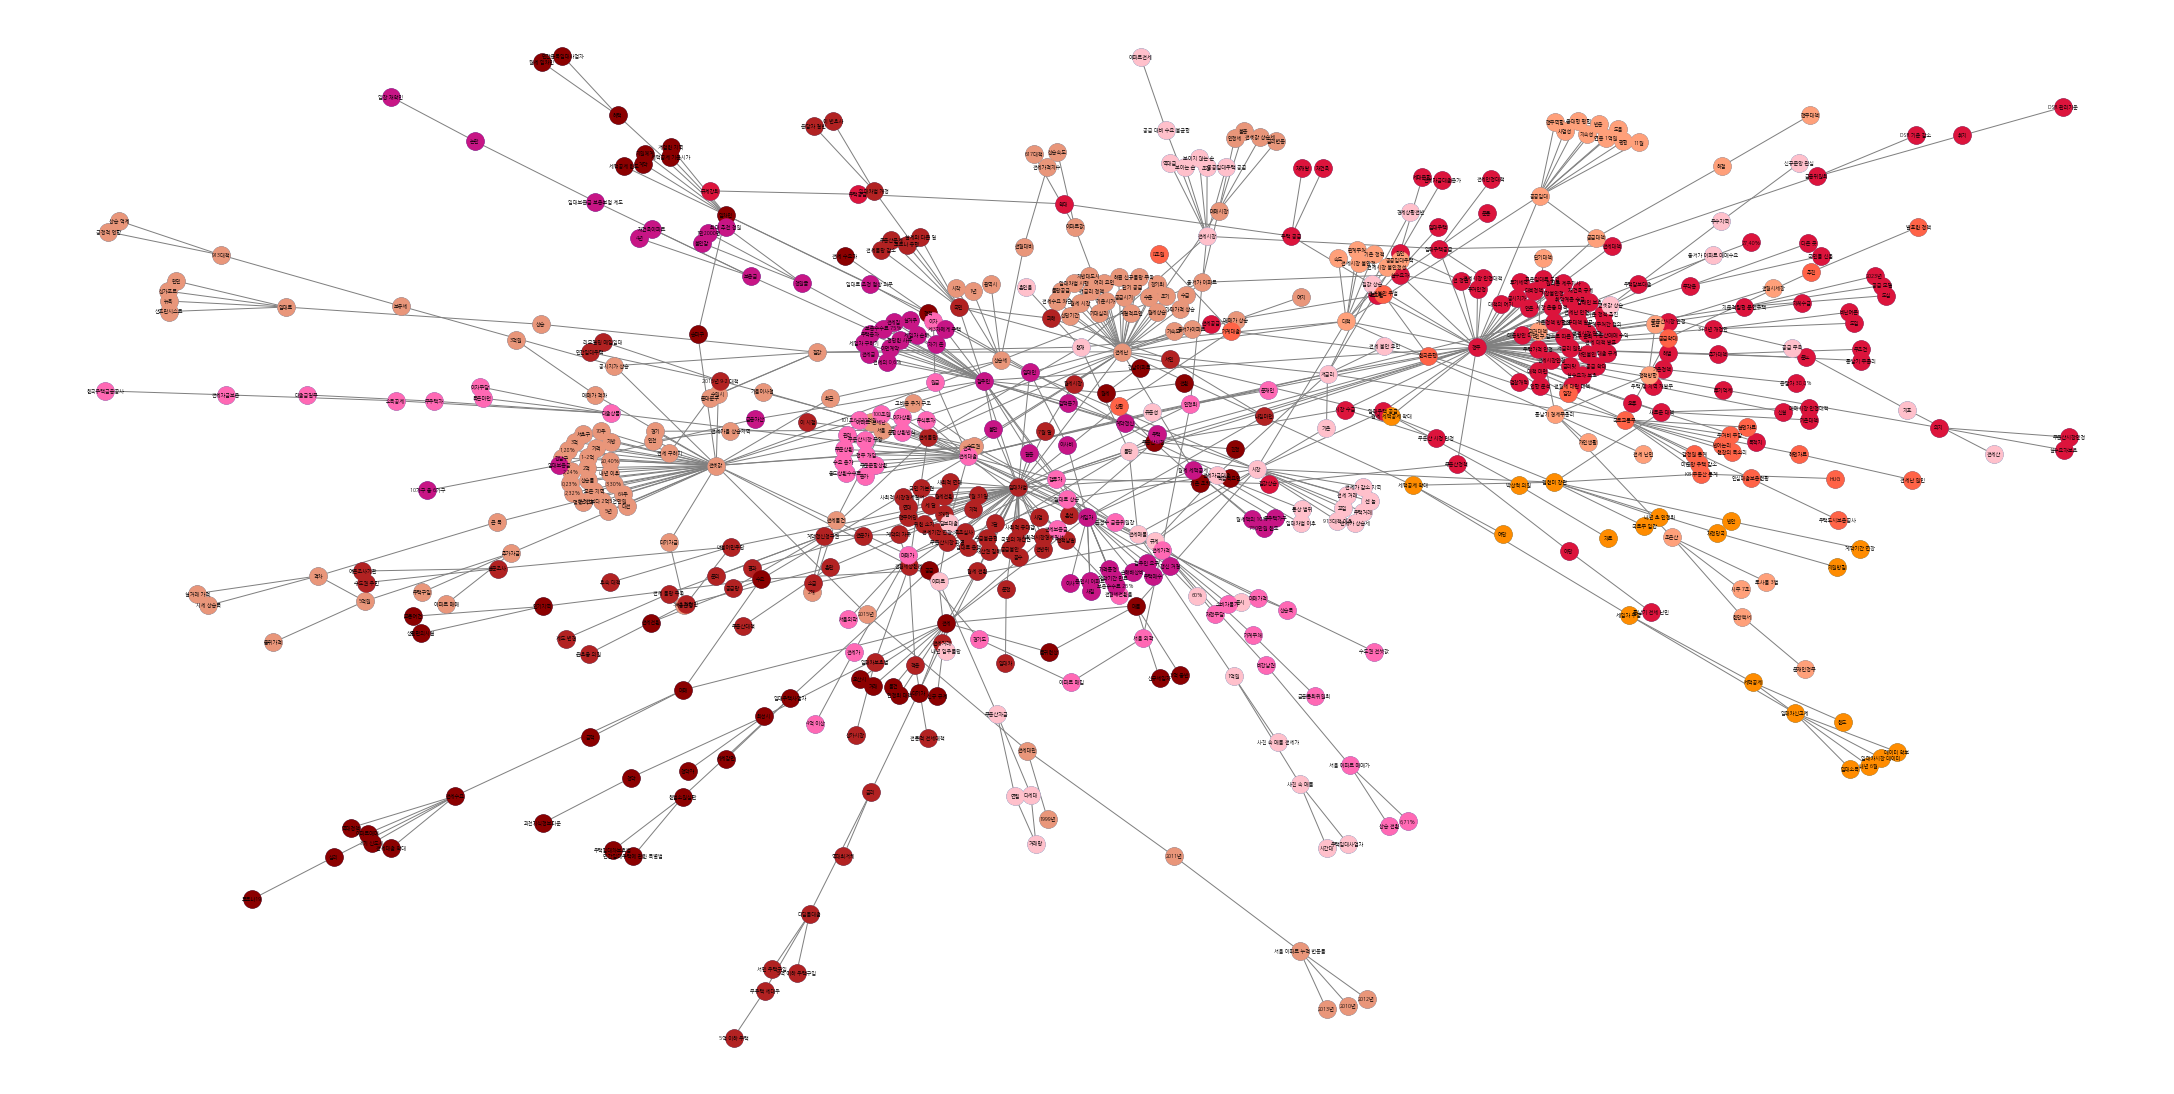

In [32]:
#클러스터가 n개인 그래프 시각
n=10
clusters = find_cluster(n)

cor_list=['r','g','b','c','m','y','orange','purple','gray','saddlebrown']
colors = ['#E9967A','#DC143C','#B22222','#8B0000','#FFC0CB','#FF69B4','#C71585','#FFA07A',\
         '#FF6347','#FF8C00','#FFD700','#BDB76B','#DDA0DD','#FF00FF','#BA55D3','#663399','#9400D3',\
         '#4B0082','#483D8B','#7CFC00','#2E8B57','#008000']

#레이아웃
#planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
#circular_layout, spring_layout, kamada_kawai_layout

# 전체 그래프 그리기
pos=nx.spring_layout(G1) 
plt.figure(figsize=(30, 15))
nx.draw(G1, pos, with_labels = True, font_weigth = "bold", font_family=font_name, font_size=5, edge_color='gray')

# 그룹이 n개로 나누어지게 node색 지정
n=len(clusters)
for i in range(n):
    nx.draw_networkx_nodes(G1,pos, nodelist=clusters[i], node_color=colors[i])   

- 클러스터별

cluster 0


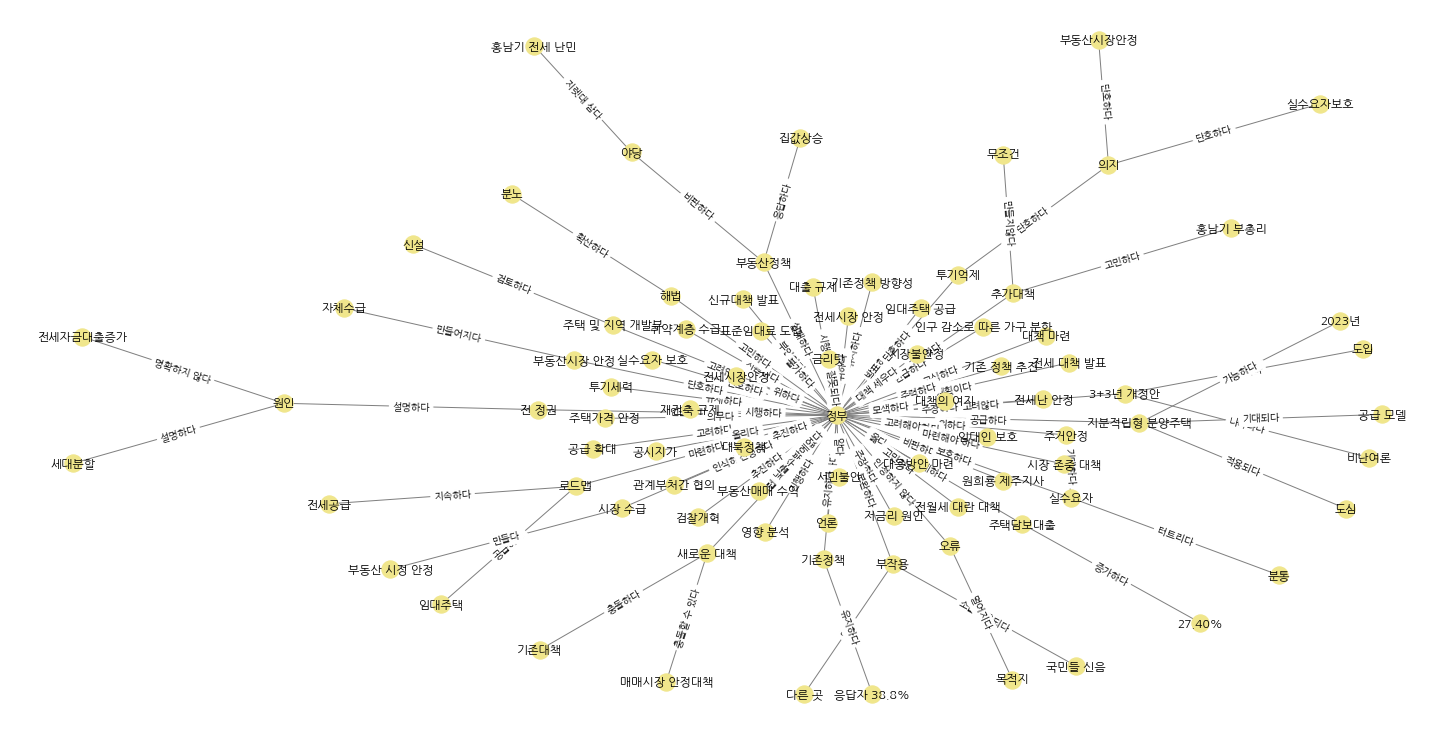

cluster 1


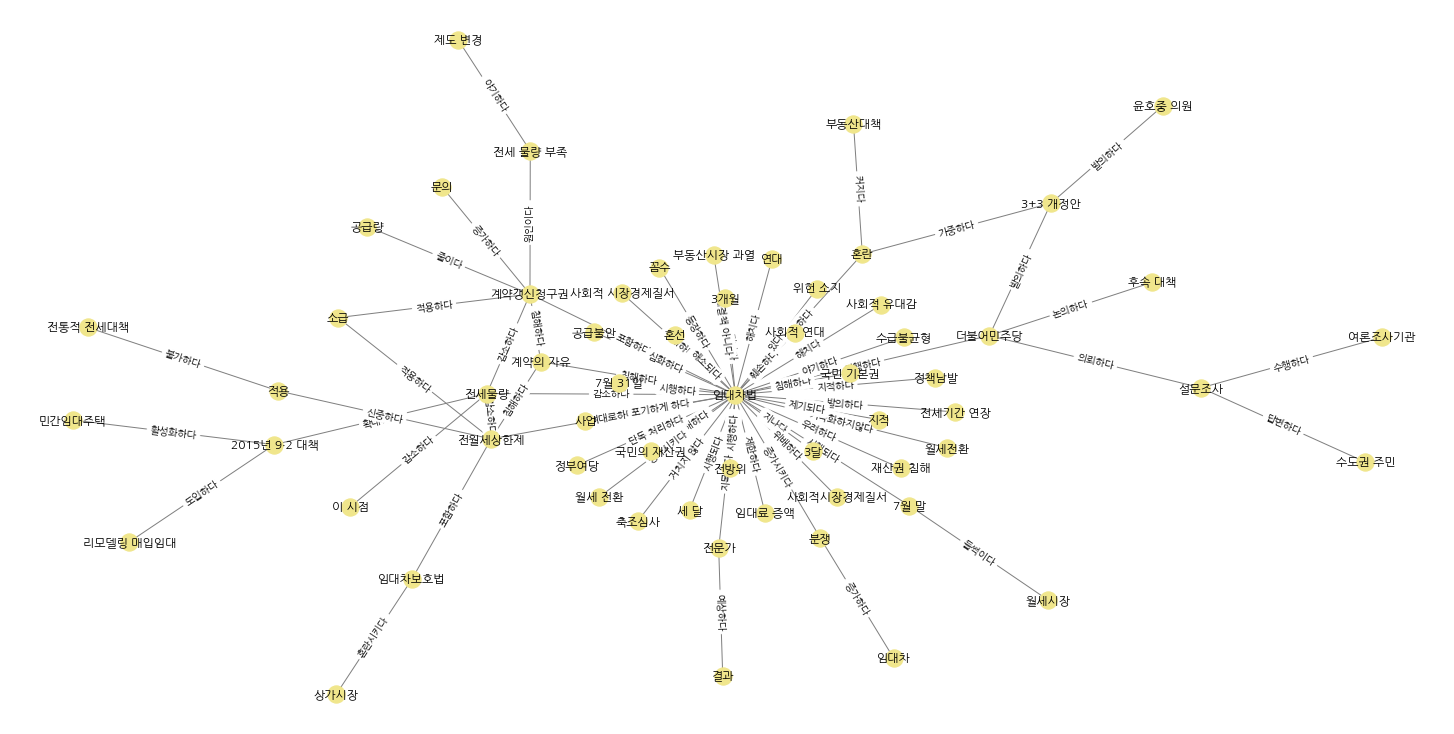

cluster 2


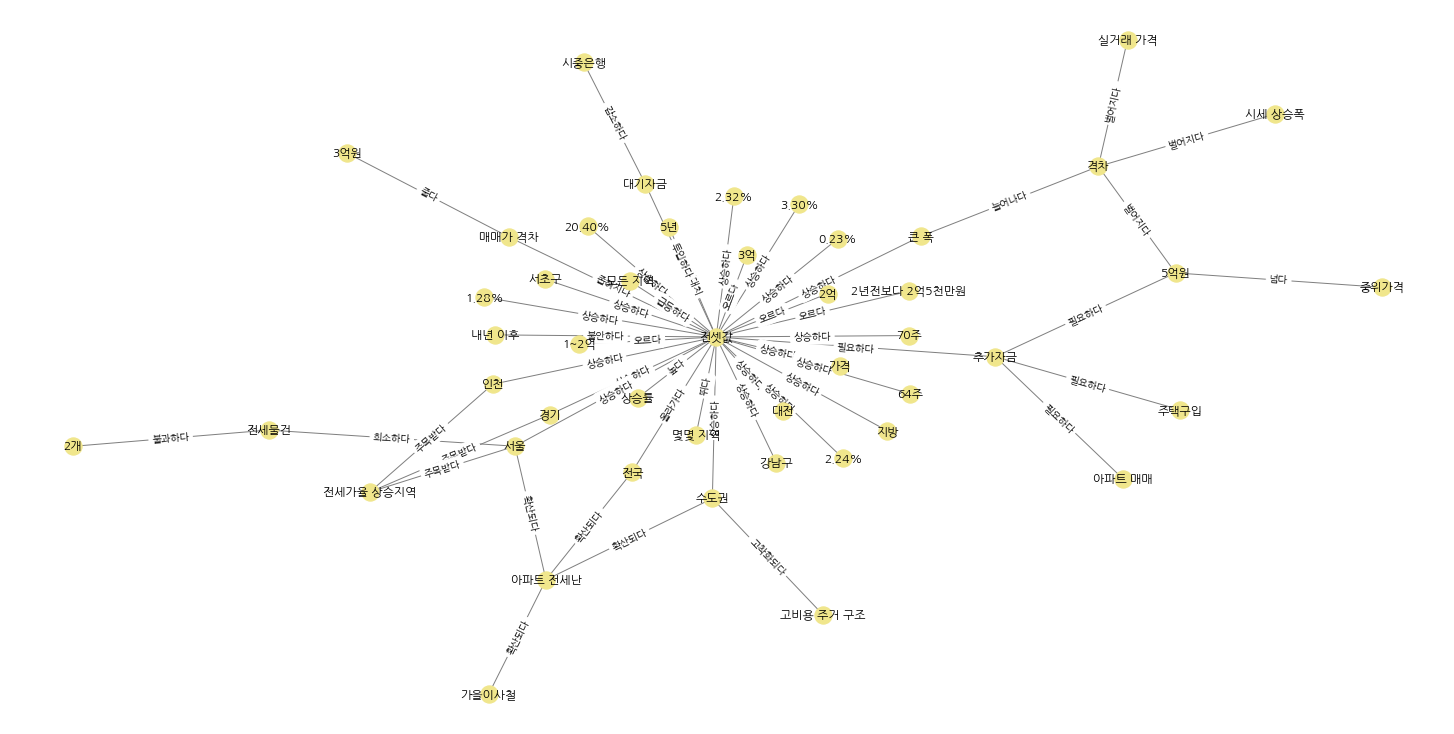

cluster 3


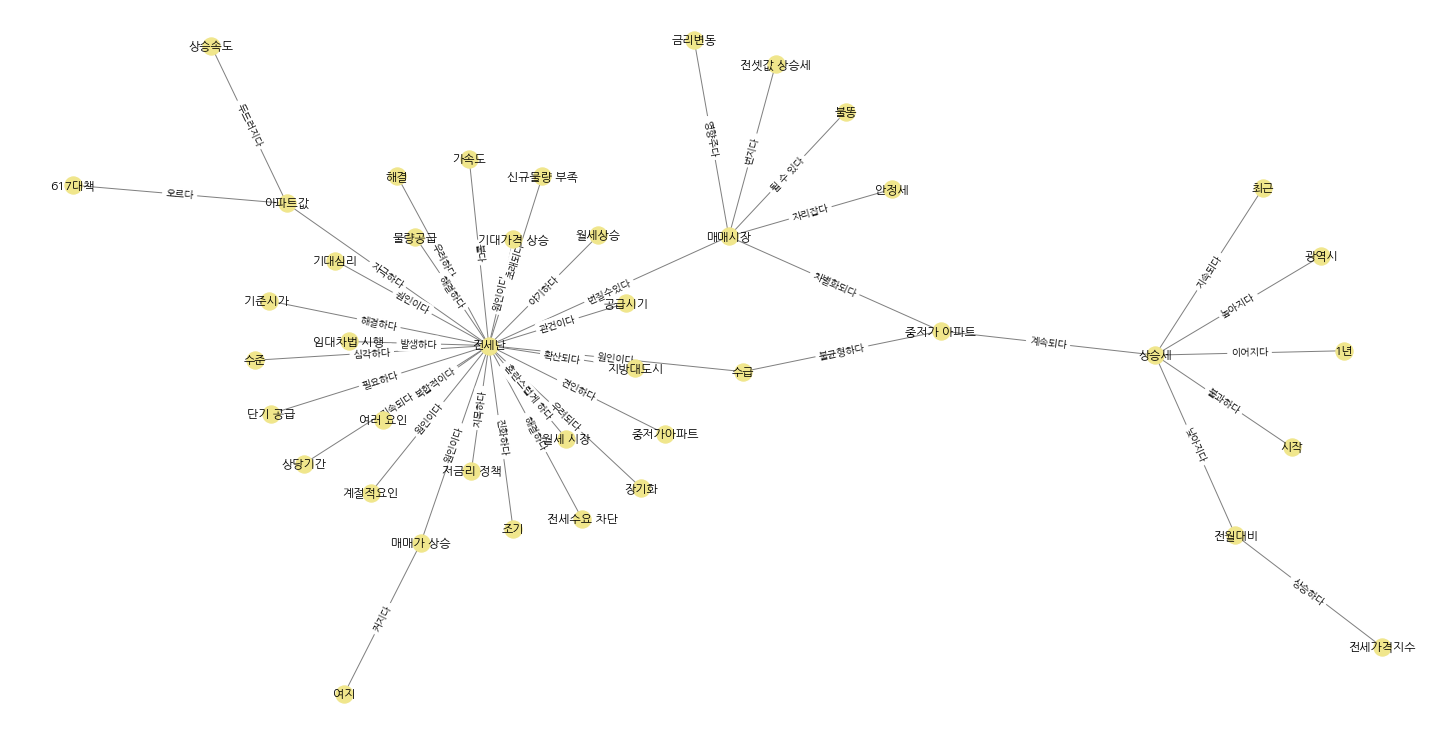

cluster 4


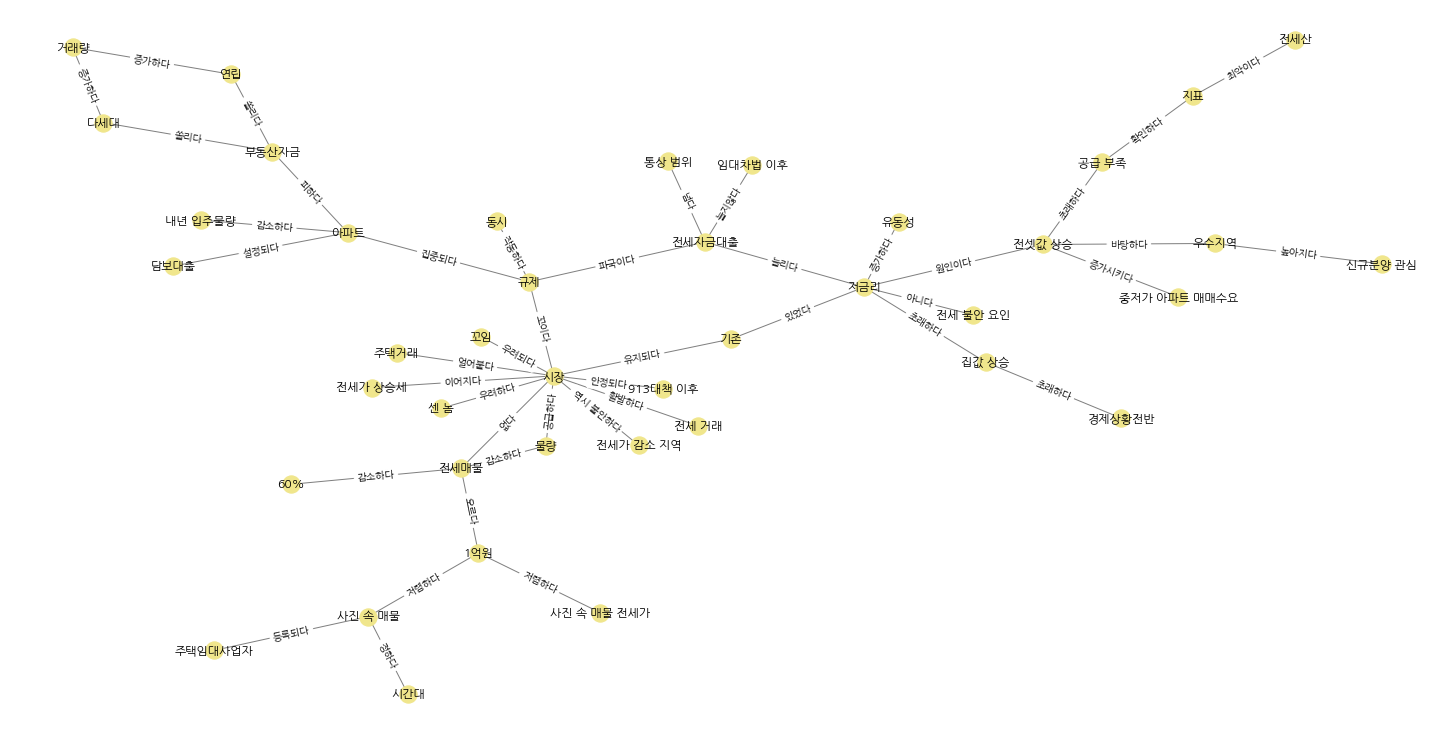

cluster 5


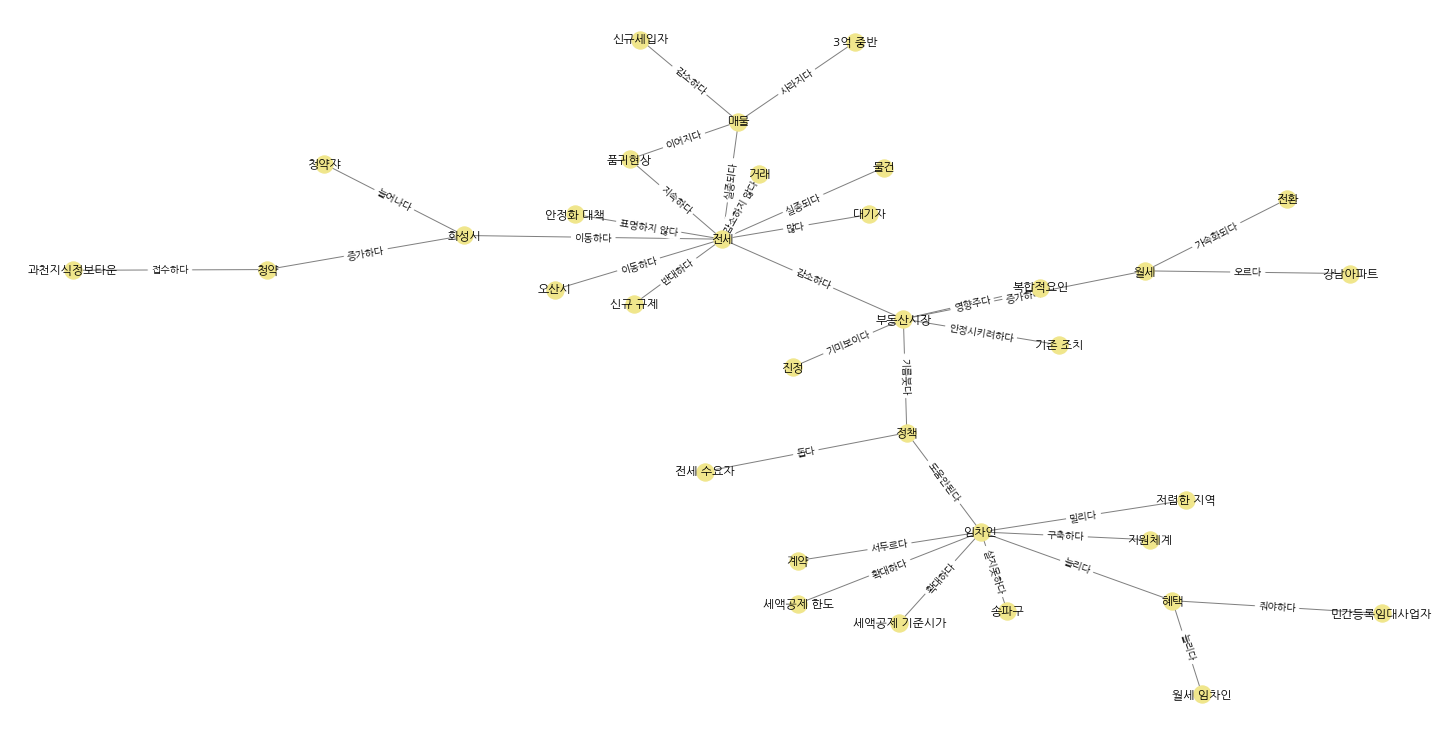

cluster 6


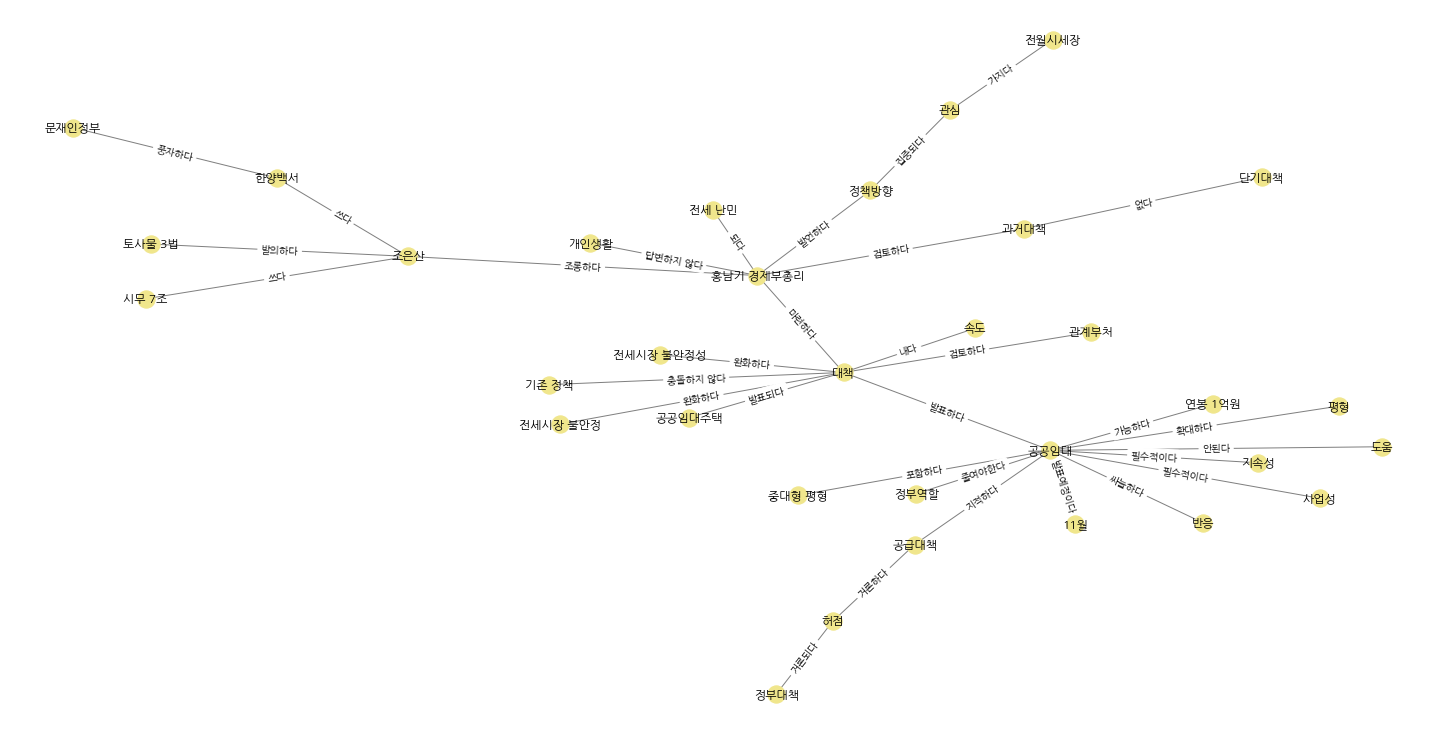

cluster 7


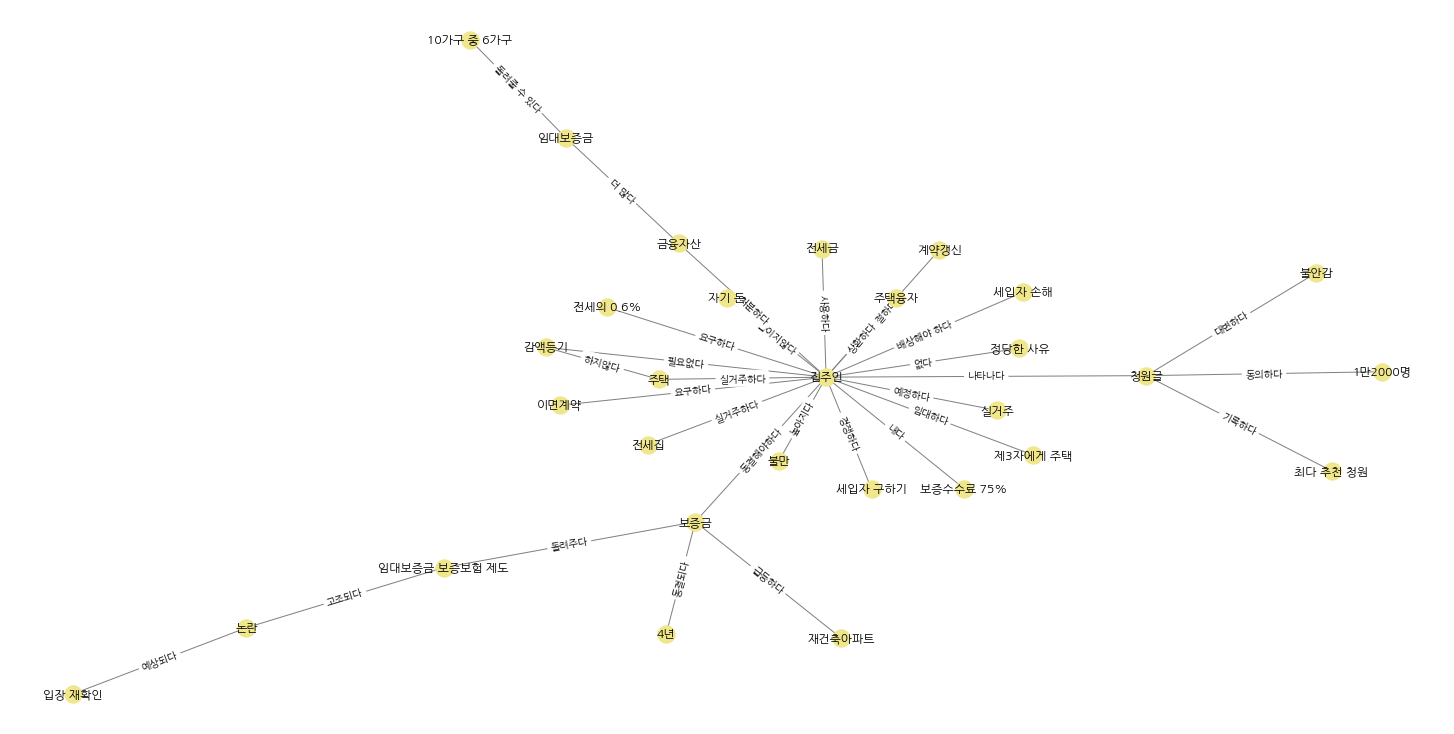

cluster 8


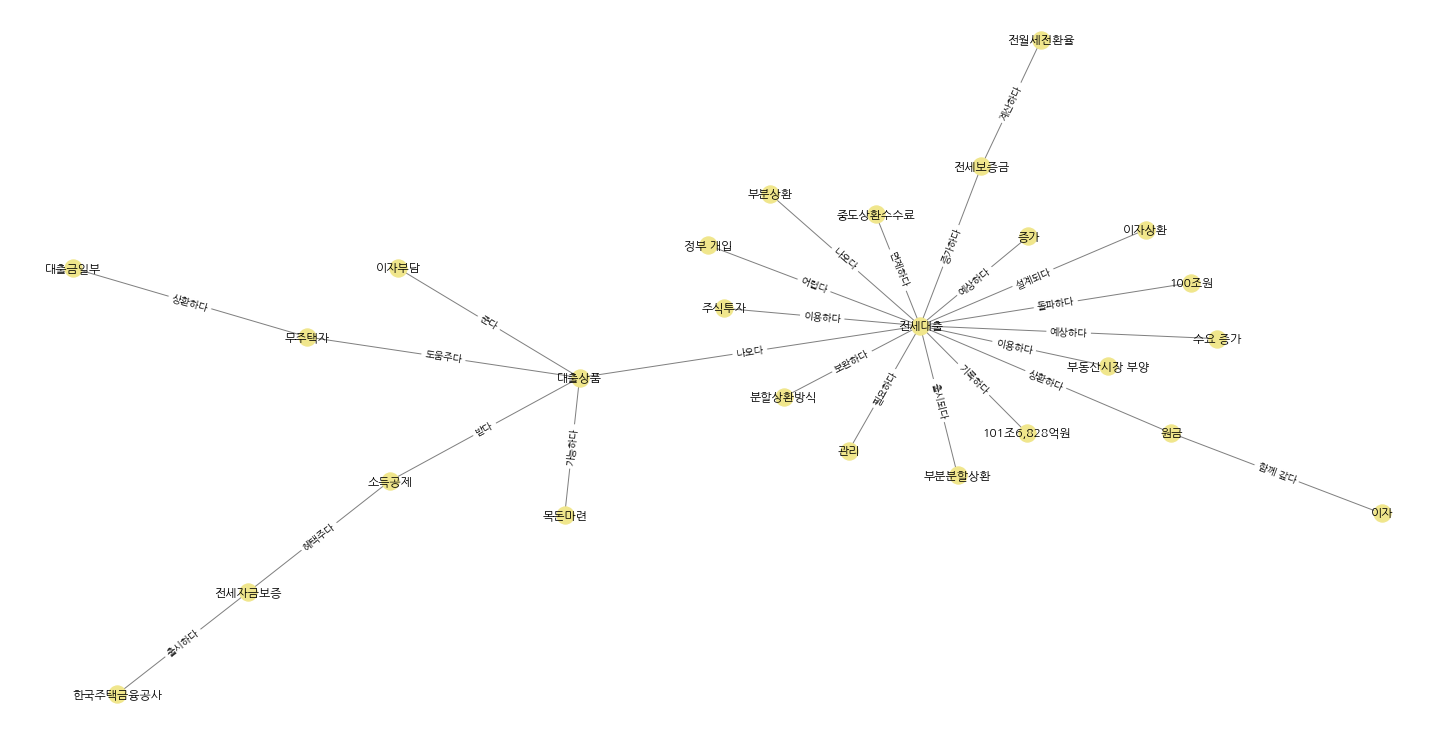

cluster 9


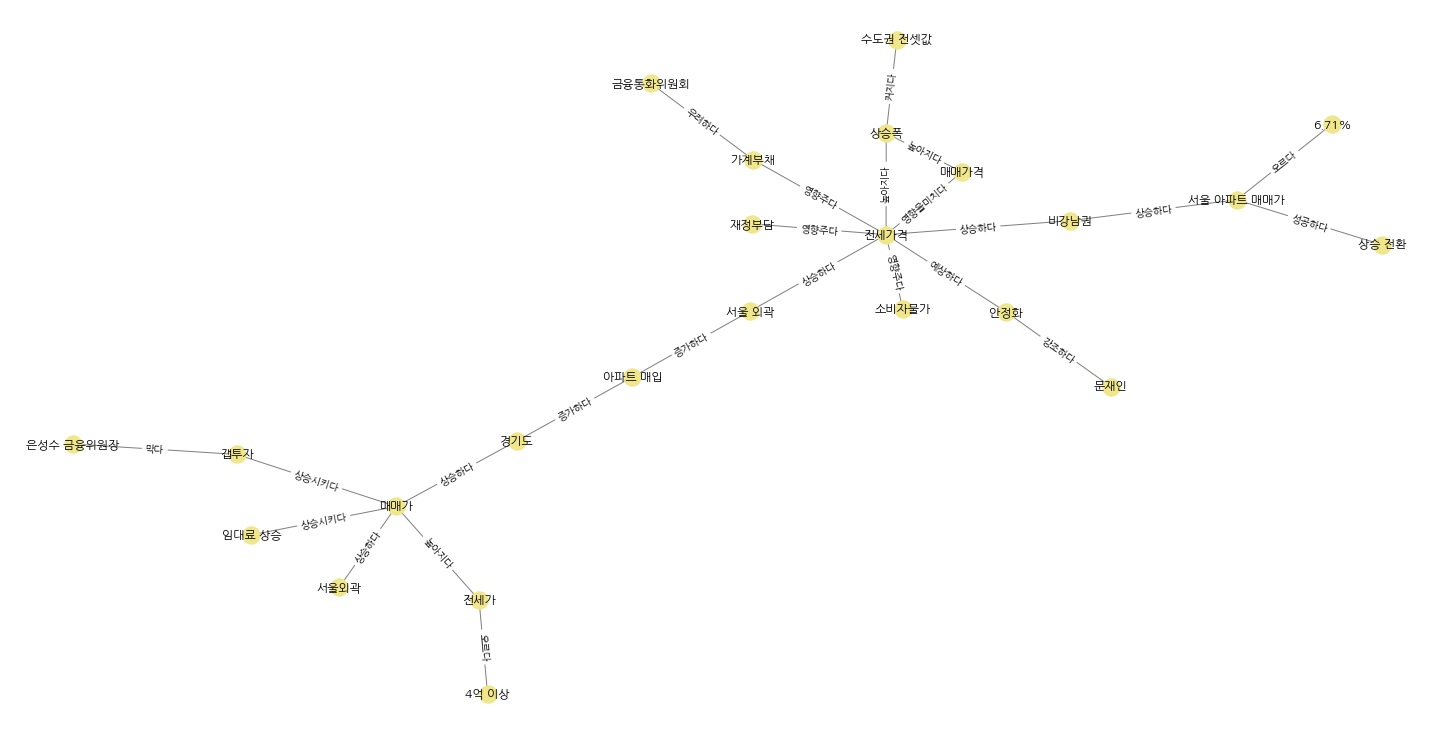

In [34]:
for i in range(len(clusters)):
    CG_0 = nx.Graph()
    CG_0.add_nodes_from(nounlist[i])

    nodes = list(spolist[i].keys())
    edges = list(spolist[i].values())

    for j in range(len(nodes)):
        CG_0.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])

    plt.figure(figsize=(20, 10))
    #레이아웃
    #planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
    #circular_layout, spring_layout, kamada_kawai_layout
    pos=nx.kamada_kawai_layout(CG_0) 
    nx.draw(CG_0, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray', node_color='khaki')

    labels = nx.get_edge_attributes(CG_0,'verb')
    nx.draw_networkx_edge_labels(CG_0, pos, edge_labels=labels, font_family=font_name)
    figname = './GN_clusters_images/'+str(i)+'.png'
    plt.savefig(figname)
    print('cluster', i)
    plt.show()